# First Order Motion Model for Image Animation
by Aliaksandr Siarohin, Stéphane Lathuilière, Sergey Tulyakov, Elisa Ricci and Nicu Sebe
###### NeurIPS 2019

Image animation consists of generating a video sequence so that an object in a source image is animated according to the motion of a driving video This Framework addresses this problem without using any annotation or prior information about the specific object to animate.Once trained on a set of videos depicting objects of the same category (e.g. faces, human bodies), this can be applied to any object of this class.

The model consist of two parts:
- Motion estimation model : predict dense motion fields
- Generation model : use source image and results from motion estimation model to generate frame.

![first order motion model architecture](https://aliaksandrsiarohin.github.io/first-order-model-website/pipeline.png)

- [First order motion page](https://aliaksandrsiarohin.github.io/first-order-model-website/)
- [Project Github](https://github.com/AliaksandrSiarohin/first-order-model)
- [Paper Link](http://papers.nips.cc/paper/8935-first-order-motion-model-for-image-animation)

I will be explaining more detailed information in later versions.

# Installing Dependencies

- OpenCV : for reading images, video and face detection using cascade classifier to crop faces from images
- First Motion Model: cloning first order motion from github
- numpy, matplotlib : for array manipulation and plotting

In [2]:
!pip install opencv-contrib-python

     |████████████████████████████████| 67.9 MB 66.8 MB/s eta 0:00:01█▋                         | 14.1 MB 6.9 MB/s eta 0:00:08


In [3]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 390 (delta 39), reused 42 (delta 19), pack-reused 312
Receiving objects: 100% (390/390), 72.19 MiB | 27.73 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [4]:
! pip install --upgrade opencv-python
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import urllib.request
warnings.filterwarnings("ignore")
from IPython.display import HTML

     |████████████████████████████████| 61.8 MB 63.0 MB/s eta 0:00:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.1.48
    Uninstalling opencv-python-4.5.1.48:
      Successfully uninstalled opencv-python-4.5.1.48


In [5]:
%matplotlib inline

# Helper Functions
- imread : read and load image from path or url in numpy array.
- vidread : read and load video from path or url as list of frames in numpy array.
- vidsave : saving video file
- display : display video and images as html
- display_image_grid : display images as grid

In [6]:
'''
    params:
        img_path : path or url to image
        size : size of image to resize, default: None (do not resize)
        scale : scale image between 0 and 1 by dividing with 255.0, default: True
    return:
        image as numpy array
'''
def imread(img_path, size=None, scale=True):
    if img_path.startswith("http://") or img_path.startswith("https://") or img_path.startswith("www."):
        resp = urllib.request.urlopen(img_path)
        img = np.asarray(bytearray(resp.read()), dtype="uint8")
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if size is not None:
            img = cv2.resize(img, size)
        if scale:
            img = np.array(img/255.0)
        return img
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    if scale:
        img = np.array(img/255.0)
    return img

In [7]:
'''
    params:
        video_path : path or url to video
        size : size of frame to resize, default: None (do not resize)
        scale : scale image between 0 and 1 by dividing with 255.0, default: True
    return:
        list of video frames as numpy array
'''
def vidread(video_path, size=None, scale=True):
    vc = cv2.VideoCapture(video_path)
    vid = []
    while vc.isOpened():
        ret, img = vc.read()
        if not ret:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if size is not None:
            img = cv2.resize(img, size)
        if scale:
            img = img/255.0
        vid.append(img)
    vc.release()
    return vid

In [8]:
'''
    params:
        save_path : path to save video
        frames : list of video frames as numpy array
        fps : framerate of video to save, default: 20
        size : size of video frames to save, default: (256,256)
    return:
        None
'''
def vidsave(save_path, frames, fps=20, size=(256,256)):
    #revert scaling factor of image and convert to uint8
    frames = np.array(frames)*255.0
    frames = frames.astype(np.uint8)
    writer = cv2.VideoWriter(save_path, 
                     cv2.VideoWriter_fourcc(*'MJPG'),
                     fps, size)
    for frame in frames:
        writer.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    writer.release()

In [9]:
'''
    params:
        source : source image
        driving : frames of driving video
        generated : frames of generated video
    return:
        animation to display in html
'''
def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

In [10]:
'''
    params:
        images : list of images to display
    return:
        None
'''
def display_image_grid(images):
    plt.title("Plot Images")
    plt.axis('off')
    plt.imshow(np.concatenate(images, axis=1))

In [11]:
'''
    changing current working path to first-order-model repo.
'''
prev_path = os.getcwd()
os.chdir("first-order-model")

# Loading pretrained model
- model is created using config file and model checkpoints are loaded.
- We have two models:
    1. keypoint detector
    2. generator model

In [12]:
config_path = "config/vox-256.yaml"
checkpoint_path = "../../input/first-order-motion/vox-cpk.pth.tar"

In [13]:
! pip install ffmpeg-python
! import ffmpeg

from demo import load_checkpoints, make_animation

generator, kp_detector = load_checkpoints(
    config_path=config_path, 
    checkpoint_path=checkpoint_path
)

import: unable to open X server `' @ error/import.c/ImportImageCommand/347.


# Source image from path
- source image is loaded from path in system
- using a driving video we animate source image

In [14]:
source_image_path = "https://github.com/shohjahonhamrayev1/create_deep_fake/blob/main/photo_2023-06-08_03-35-48.jpg"
driving_video_path = "../../input/first-order-motion/10.mp4"

In [15]:
source_image = imread(source_image_path, size=(256, 256))
driving_video = vidread(driving_video_path, size=(256,256))

In [16]:
HTML(display(source_image, driving_video).to_html5_video())

here we generate animated video of source image using motion of driving image

In [17]:
# with relative = True (source image is animated relative to transforms of itself)
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)
HTML(display(source_image, driving_video, predictions).to_html5_video())

  0%|          | 0/444 [00:00<?, ?it/s]

In [18]:
save_path = "../got03.avi"
vidsave(save_path, predictions, fps=20, size=(256,256))

In [19]:
# with relative = False (source image is animated with respect to transform of driving video)
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False,
                            adapt_movement_scale=False)
HTML(display(source_image, driving_video, predictions).to_html5_video())

  0%|          | 0/444 [00:00<?, ?it/s]

In [20]:
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, 
                             adapt_movement_scale=True)
HTML(display(source_image, driving_video, predictions).to_html5_video())

  0%|          | 0/444 [00:00<?, ?it/s]

# Face detection to crop faces from image
- It uses faces haarcascde to detect faces which is fast and give decent results.
- We detect all faces and return list of crops of these faces.

In [21]:
'''
    params:
        image : image to crop faces from
        haarcascade_path : path to haarcascde xml file
        size : size of cropped face images
        margin_around : margin around detect box around face.
            this is used to include some parts around faces like hair, neck soulders etc. value is tuned based on output needed.
    return:
        list of cropped images of faces
'''
def crop_faces(image, haarcascade_path, size=(256,256), margin_around=50):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    detector = cv2.CascadeClassifier(haarcascade_path)
    rects = detector.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=10, minSize=(30,30), flags=cv2.CASCADE_SCALE_IMAGE)
    crop_images = []
    for x, y, w, h in rects:
        a = 0 if y - margin_around < 0 else y - margin_around
        b = 0 if x - margin_around < 0 else x - margin_around
        img = image[a:y + h + margin_around, b:x + w + margin_around]
        img = cv2.resize(img, size)
        crop_images.append(img)
    return crop_images

downloading face haarcascade xml file from opencv github

In [22]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2023-06-08 11:26:43--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2023-06-08 11:26:44 (29.3 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



# Source Image from URL
- loading image from a internet using its url.

In [31]:
source_image_url = "https://github.com/shohjahonhamrayev1/create_deep_fake/blob/main/photo_2023-06-08_03-35-54.jpg.jpg"
driving_video_path = "../../input/first-order-motion/00.mp4"

In [32]:
source_image = imread(source_image_url, size=(256,256), scale=False)
driving_video = vidread(driving_video_path, size=(256,256))

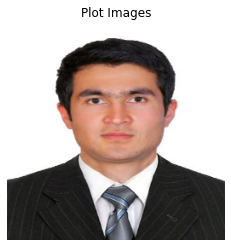

In [33]:
display_image_grid([source_image])

In [34]:
haarcascade_path = "haarcascade_frontalface_default.xml"
margin_around = 20

Get all cropped face images from source image to transfer motion from driving video.

In [35]:
crop_images = crop_faces(source_image, haarcascade_path=haarcascade_path, size=(256,256), margin_around=margin_around)
crop_images = np.array(crop_images)/255.0

Number of Faces in image:  1


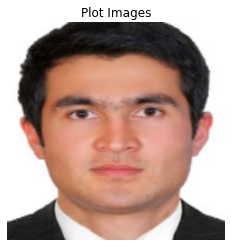

In [36]:
print("Number of Faces in image: ", len(crop_images))
display_image_grid(crop_images)

Select a cropped image from all cropped faces we get using its index

In [37]:
face_index = 0

In [38]:
HTML(display(crop_images[face_index], driving_video).to_html5_video())

creating and saving animated video based on motion from driving video

In [39]:
predictions = make_animation(crop_images[face_index], driving_video, generator, kp_detector, relative=True)
HTML(display(crop_images[face_index], driving_video, predictions).to_html5_video())

  0%|          | 0/265 [00:00<?, ?it/s]

In [40]:
save_path = "../test.avi"
vidsave(save_path, predictions, fps=20, size=(256,256))

In [41]:
os.chdir(prev_path)
!rm -rf first-order-model